In [1]:
%matplotlib inline

In [2]:
import sys
sys.executable

'/usr/local/opt/python/bin/python3.7'

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/vgg19

In [3]:
# Imports
import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [4]:
# Output files
model_type='vgg19'
no_of_images = 1000
EPOCHS = 10
_APPEND = '_' + model_type + '_' + str(no_of_images) + '_' + str(EPOCHS)  
APPEND = _APPEND + ".png"

TRAINING_LOGS_FILE = "training_logs/training_logs" + _APPEND + '.csv'
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_PLOT_FILE = "plots/model_plot_" + APPEND
MODEL_FILE = "model/model_vgg19_1000.h5"
TRAINING_PLOT_FILE = "plots/training" +  APPEND
VALIDATION_PLOT_FILE = "plots/validation" + APPEND
ROC_PLOT_FILE = "plots/roc" + APPEND

In [5]:
# Hyperparams
#SAMPLE_COUNT = 85000
#TRAINING_RATIO = 0.9
IMAGE_SIZE = 96 
IMAGE_SIZE2 = 224

BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 100

In [6]:
SAMPLE_COUNT = 200
TRAINING_RATIO = 0.9
TESTING_BATCH_SIZE = 100
BATCH_SIZE = 10

In [7]:
# Origina data file Data (https://www.kaggle.com/c/histopathologic-cancer-detection/data)
#input_dir = '../input/'
input_dir = './dataset/'
training_dir = input_dir + 'train1000/'
data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})
data_frame.head()

,path
0,./dataset/train1000/f0c2a0b8ef3024f407fa97d852...
1,./dataset/train1000/99ef485f205645918613cd0428...
2,./dataset/train1000/e2612e173abd0e8bb54a3c3db3...
3,./dataset/train1000/6d1bb57c0606f05dbd75f90a8d...
4,./dataset/train1000/9c043ab2adadfeb758c71d2143...


In [8]:
data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split('.')[0])
#data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3])
data_frame.head()

,path,id
0,./dataset/train1000/f0c2a0b8ef3024f407fa97d852...,f0c2a0b8ef3024f407fa97d852d49be0215cafe0
1,./dataset/train1000/99ef485f205645918613cd0428...,99ef485f205645918613cd04281098daa7c17819
2,./dataset/train1000/e2612e173abd0e8bb54a3c3db3...,e2612e173abd0e8bb54a3c3db3f264b63d80bffb
3,./dataset/train1000/6d1bb57c0606f05dbd75f90a8d...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0
4,./dataset/train1000/9c043ab2adadfeb758c71d2143...,9c043ab2adadfeb758c71d21432fccd3e43565c0


In [9]:
labels = pd.read_csv(input_dir + 'train_labels.csv')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
data_frame = data_frame.merge(labels, on='id')
print(data_frame.count(axis=0))
negatives = data_frame[data_frame.label == 0].sample(SAMPLE_COUNT)
positives = data_frame[data_frame.label == 1].sample(SAMPLE_COUNT)
data_frame = pd.concat([negatives, positives]).reset_index()
data_frame = data_frame[['path', 'id', 'label']]
data_frame['image'] = data_frame['path'].map(imread)

path     1000
id       1000
label    1000
dtype: int64


In [11]:
data_frame.head()

,path,id,label,image
0,./dataset/train1000/38c4c38fa7ee4b152348a306e9...,38c4c38fa7ee4b152348a306e920d4a998c38b8f,0,"[[[250, 183, 224], [159, 103, 142], [201, 159,..."
1,./dataset/train1000/2d9c9960bae80dcffe43c08653...,2d9c9960bae80dcffe43c08653d0f3224cee7c05,0,"[[[156, 107, 212], [76, 32, 130], [42, 3, 92],..."
2,./dataset/train1000/24e7145facb81560da801be19d...,24e7145facb81560da801be19d1e4b1b965840d8,0,"[[[247, 247, 247], [246, 246, 246], [246, 246,..."
3,./dataset/train1000/b3fd8c60c46787b46d0c167fc4...,b3fd8c60c46787b46d0c167fc48ede6f83936f17,0,"[[[156, 96, 122], [225, 166, 194], [193, 137, ..."
4,./dataset/train1000/b2ebdb3bc2f6ddda67fa8b9f0a...,b2ebdb3bc2f6ddda67fa8b9f0a72d50bc2b4b2aa,0,"[[[227, 226, 231], [227, 226, 231], [227, 226,..."


In [12]:
training_path = './training1000'
validation_path = './validation1000'


In [13]:
for folder in [training_path, validation_path]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        #os.makedirs(path, exist_ok=True)
        print('path exists? ' + path + ":" + str(os.path.exists(path)))
        if not os.path.exists(path):
            print('Creating dirs: ' + path)
            os.makedirs(path)

path exists? ./training1000/0:True
path exists? ./training1000/1:True
path exists? ./validation1000/0:True
path exists? ./validation1000/1:True


In [14]:
training, validation = train_test_split(data_frame, train_size=TRAINING_RATIO, stratify=data_frame['label'])

data_frame.set_index('id', inplace=True)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
for images_and_path in [(training, training_path), (validation, validation_path)]:
    images = images_and_path[0]
    path = images_and_path[1]
    if not os.path.exists(path):
        for image in images['id'].values:
            file_name = image + '.tif'
            label = str(data_frame.loc[image,'label'])
            destination = os.path.join(path, label, file_name)
            print(destination + ': os.path.exists?' + str(os.path.exists(destination)))
            if not os.path.exists(destination):
                source = os.path.join(input_dir + 'train1000', file_name)
                shutil.copyfile(source, destination)
    else:
        print(path + ' already exists')

./training1000 already exists
./validation1000 already exists


In [16]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=180,
                                             zoom_range=0.4, 
                                             width_shift_range=0.3,
                                             height_shift_range=0.3,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

In [17]:
# Data generation
training_generator = training_data_generator.flow_from_directory(training_path,
                                                                 target_size=(IMAGE_SIZE2,IMAGE_SIZE2),
                                                                 batch_size=BATCH_SIZE,
                                                                 class_mode='binary')
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                              target_size=(IMAGE_SIZE2,
                                                                                           IMAGE_SIZE2),
                                                                              batch_size=BATCH_SIZE,
                                                                              class_mode='binary')
testing_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                           target_size=(IMAGE_SIZE2,IMAGE_SIZE2),
                                                                           batch_size=BATCH_SIZE,
                                                                           class_mode='binary',
                                                                           shuffle=False)

Found 874 images belonging to 2 classes.
Found 185 images belonging to 2 classes.
Found 185 images belonging to 2 classes.


In [18]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 253f8cb515780f3b799900260a226db6 so we will re-download the data.
80142336/80134624 [==============================] - 44s 1us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513     

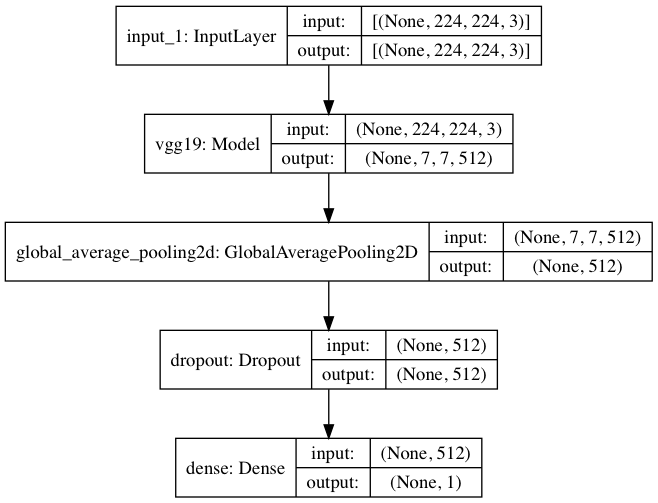

In [19]:
# Model
input_shape = (IMAGE_SIZE2, IMAGE_SIZE2, 3)
inputs = Input(input_shape)

vgg19 = VGG19(include_top=False, input_shape=(224, 224, 3))(inputs) 
outputs = GlobalAveragePooling2D()(vgg19)
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

plot_model(model,
           to_file=MODEL_PLOT_FILE,
           show_shapes=True,
           show_layer_names=True)

In [20]:
#  Training
history = model.fit_generator(training_generator,
                              steps_per_epoch=len(training_generator), 
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=EPOCHS,
                              verbose=VERBOSITY,
                              callbacks=[#PlotLossesKeras(),
                                         ModelCheckpoint(MODEL_FILE,
                                                         monitor='val_accuracy',
                                                         verbose=VERBOSITY,
                                                         save_best_only=True,
                                                         mode='max'),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=True,
                                                   separator=';')
                              ])

Epoch 1/10


W0820 12:23:28.312226 140735764751232 deprecation.py:323] From /Users/rdua/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


87/88 [============================>.] - ETA: 8s - loss: 0.6688 - accuracy: 0.5475 
Epoch 00001: val_accuracy improved from -inf to 0.49730, saving model to model/model_vgg19_1000.h5
88/88 [==============================] - 819s 9s/step - loss: 0.6693 - accuracy: 0.5458 - val_loss: 0.6597 - val_accuracy: 0.4973
Epoch 2/10
87/88 [============================>.] - ETA: 11s - loss: 0.6424 - accuracy: 0.5602
Epoch 00002: val_accuracy improved from 0.49730 to 0.61622, saving model to model/model_vgg19_1000.h5
88/88 [==============================] - 1100s 13s/step - loss: 0.6419 - accuracy: 0.5606 - val_loss: 0.6494 - val_accuracy: 0.6162
Epoch 3/10
87/88 [============================>.] - ETA: 9s - loss: 0.6667 - accuracy: 0.5475 
Epoch 00003: val_accuracy did not improve from 0.61622
88/88 [==============================] - 909s 10s/step - loss: 0.6673 - accuracy: 0.5446 - val_loss: 0.6628 - val_accuracy: 0.4973
Epoch 4/10
87/88 [============================>.] - ETA: 42s - loss: 0.6941 -

In [21]:
history.history

{'loss': [0.6705121528229397,
  0.6414744364997069,
  0.668204955296331,
  0.6934132493469753,
  0.6013208650205992,
  0.5755305041983144,
  0.5534574769999943,
  0.5489433423468941,
  0.531763786309371,
  0.5381881629097652],
 'accuracy': [0.5457666,
  0.56064075,
  0.5446224,
  0.56979406,
  0.687643,
  0.7208238,
  0.7242563,
  0.73798627,
  0.7528604,
  0.7402746],
 'val_loss': [0.6597081422805786,
  0.6494181689463163,
  0.6628176538567794,
  0.6489598907922444,
  0.6141646488716728,
  0.7007122996606325,
  0.48943334112041875,
  0.5481455404507486,
  0.4910066551283786,
  0.5171090317399878],
 'val_accuracy': [0.4972973,
  0.61621624,
  0.4972973,
  0.6864865,
  0.75135136,
  0.6108108,
  0.7675676,
  0.75135136,
  0.78918916,
  0.74594593]}

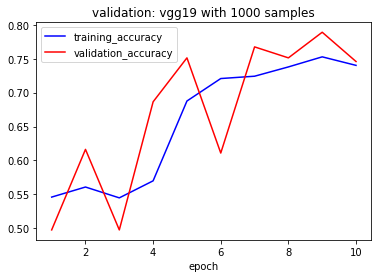

In [22]:
# Training plots
common_title = model_type + ' with ' + str(no_of_images) + ' samples'
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training: ' + common_title)
plt.xlabel('epoch')
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.close()

plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation: ' + common_title)
plt.xlabel('epoch')
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.show()
plt.close()

19/19 [==============================] - 41s 2s/step


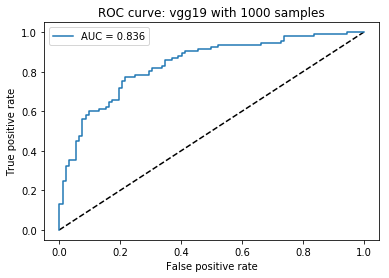

In [23]:
# ROC testing plot
#model.load_weights(MODEL_FILE)
predictions = model.predict_generator(testing_generator, steps=len(testing_generator), verbose=VERBOSITY)
false_positive_rate, true_positive_rate, threshold = roc_curve(testing_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: ' + common_title)
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()
plt.close()

In [25]:
VGG19.summary()

AttributeError: 'function' object has no attribute 'summary'